![](img/banner_purse.jpg)

# Image Classification: Lady Purses

## Create download lists

1. Go to [Google Images](http://images.google.com) and search for the images.
2. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do, so it is a good idea to put keywords you want to exclude into the search query, i.e. if you are searching for the Eurasian wolf, "canis lupus lupus", you might want to use the query:
>*"canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis*
3. Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.
4. Press `Cmd+Opt+J` in Mac, and a Javascript console will appear. That is where you will paste the JS commands to download a list of urls as a csv file

**(Note: turn off the ad blocker before you download)**.

```js
*urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```


## Imports

In [ ]:
from fastai import *
from fastai.vision import *

In [ ]:
plt.style.use(['dark_background'])

## Paths

In [ ]:
PATH = Path('data/classifier/purses')
TRN_PATH = PATH/'train'
TST_PATH = PATH/'test'

## Downlaod images

In [ ]:
for p in TRN_PATH.glob("*.txt"):
    dest = p.parent/str(p.stem).split('_')[1]
    dest.mkdir(parents=True, exist_ok=True)
    download_images(p, dest)

## Verfify images

Then we can remove any images that can't be opened:

In [ ]:
for p in TRN_PATH.glob("*.txt"):
    dest = p.parent/str(p.stem).split('_')[1]
    print(dest)
    verify_images(dest, delete=True, max_workers=8)

In [ ]:
import PIL
for fn in TRN_PATH.glob('*/*.jpg'):
    im = PIL.Image.open(fn)
    if im.mode != 'RGB': im.convert('RGB').save(fn)

## Data preparation and sanity check

In [ ]:
#np.random.seed(66)
#data = ImageDataBunch.from_folder(PATH, train=".", valid_pct=0.2,
#        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

#data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
#         ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0),
#                                   size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
np.random.seed(66)
data = (ImageFileList.from_folder(TRN_PATH)
        .label_from_folder()
        .random_split_by_pct(valid_pct=0.2)
        .datasets(ImageClassificationDataset)
        .transform(get_transforms(), size=224)
        .databunch(bs=64)
        .normalize(imagenet_stats))

Let's take a look at some of our pictures then.

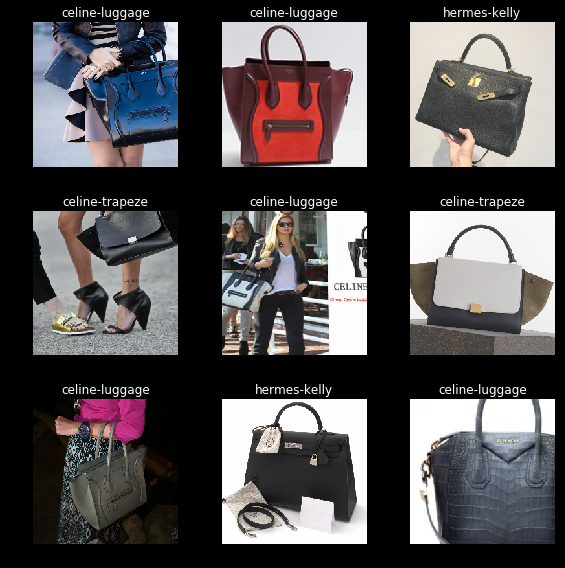

In [ ]:
data.show_batch(rows=3, figsize=(8,8))

In [ ]:
data.classes

['celine-trapeze', 'hermes-kelly', 'celine-luggage', 'channel-flap']

In [ ]:
data.c, len(data.train_ds), len(data.valid_ds)

(4, 1227, 306)

## Train

- Most of the time things will train fine with the defaults
- There's not much you really need to tune.
- Most likely are
  - Learning rate
  - Number of epochs

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)
#learn = create_cnn(data, models.resnet50, metrics=error_rate, ps=0, wd=0)

In [ ]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


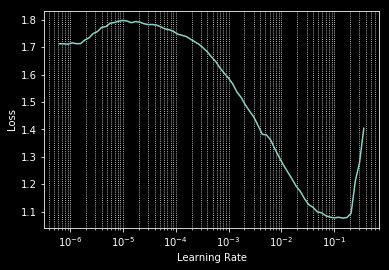

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [ ]:
learn.fit_one_cycle(4,max_lr=slice(5e-4,2e-2))

Total time: 01:36
epoch  train_loss  valid_loss  error_rate
1      0.742364    0.530329    0.124183    (00:24)
2      0.546244    0.465167    0.104575    (00:21)
3      0.430645    0.376845    0.088235    (00:26)
4      0.338774    0.372147    0.088235    (00:23)



In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


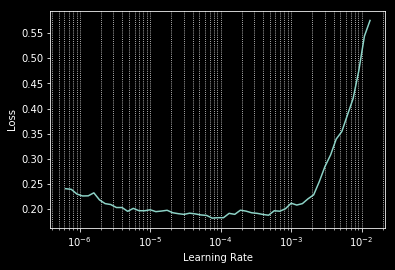

In [ ]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [ ]:
learn.fit_one_cycle(15, max_lr=slice(8e-7,1.7e-6))

Total time: 05:59
epoch  train_loss  valid_loss  error_rate
1      0.223670    0.379716    0.088235    (00:23)
2      0.190021    0.362060    0.088235    (00:23)
3      0.192133    0.370461    0.088235    (00:24)
4      0.187812    0.364655    0.084967    (00:24)
5      0.196521    0.354447    0.084967    (00:23)
6      0.184285    0.353727    0.088235    (00:21)
7      0.176832    0.354247    0.084967    (00:25)
8      0.174222    0.344343    0.084967    (00:24)
9      0.168120    0.340746    0.081699    (00:23)
10     0.162049    0.340178    0.081699    (00:25)
11     0.162488    0.337188    0.078431    (00:23)
12     0.157329    0.342254    0.084967    (00:23)
13     0.160442    0.347032    0.084967    (00:23)
14     0.153687    0.337583    0.081699    (00:23)
15     0.161922    0.334457    0.084967    (00:23)



In [ ]:
learn.save('stage-2')

## Interpretation

In [ ]:
learn.load('stage-2')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

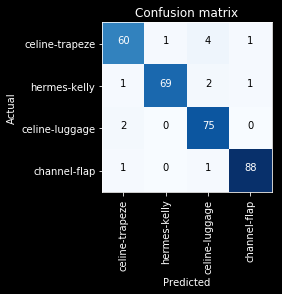

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val=1)

[('celine-trapeze', 'celine-luggage', 4),
 ('hermes-kelly', 'celine-luggage', 2),
 ('celine-luggage', 'celine-trapeze', 2)]

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our dataset that shouldn't be. In this case, we would use the `FileDeleter` widget from `fastai.widgets` so we can prune our top losses, removing photos that don't belong.

1. First we need to get the file paths from our top_losses. Here's a handy function that pulls out all our top_losses:

In [ ]:
from fastai.widgets import *

In [ ]:
losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

2. Now we can pass in these file file paths to our widget.
    - Flag photos for deletion by clicking 'Delete'.
    - Then click 'Confirm' to delete flagged photos and keep the rest in that row. 
    - The `File_Deleter` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses`.
    
    **(Note: this widget does not work in Jupyter Lab but perfectly in Jupyter NB)**

In [ ]:
fd = FileDeleter(file_paths=top_loss_paths)

Button(button_style='primary', description='Confirm', style=ButtonStyle())

## Putting your model in production

In [ ]:
data.classes

['celine-trapeze', 'hermes-kelly', 'celine-luggage', 'channel-flap']

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
# fastai.defaults.device = torch.device('cpu')

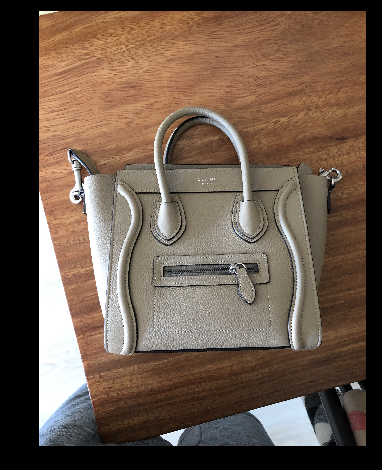

In [ ]:
img = open_image(TST_PATH/'testimg.jpg')
img.show(figsize=(6, 8))

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'celine-luggage'

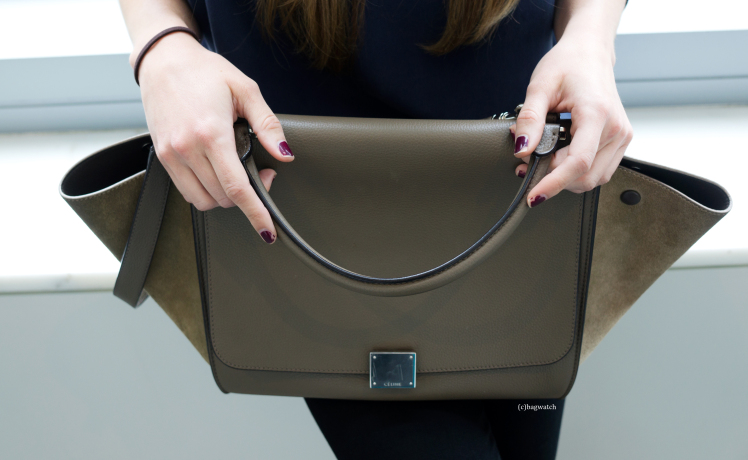

In [ ]:
img = open_image(TRN_PATH/'celine-trapeze'/'00000077.jpg')
img

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'celine-trapeze'

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)